# Generative Adversarial Network (GAN)
Since GANs were introduced in 2014 by Google Researcher Ian Goodfellow, the tech has been widely adopted in image generation and transfer. After some early wiry failures, GANs have made huge breakthroughs and can now produce highly convincing fake images of animals, landscapes, human faces, etc. Researchers know what GANs can do, however a lack of transparency in their inner workings means GAN improvement is still achieved mainly through trial-and-error. This allows only limited control over the synthesized images

-------------
## Packages
Let's first import the necessary packages,

In [1]:
import numpy as np
import torch.utils.data as data
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.autograd import Variable
from torch.utils.data import DataLoader
%matplotlib inline

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

print(device)

cuda


-----
## Configuration
### hyper parameters
We then set up and hyper parameters that need for the our model.
we need to define several hyper parameters for our model:
1. latent size
2. hidden size
3. input image size
4. numbper of epoches
5. batch size
6. out put directory

In [3]:
data = "/home/mmvc/img"

batch_size = 128
epochs_num=4
image_size = 64

-----
##  Image processing
Then, we define a image preprocessing object that our dataloader can directly use this object to preprocess our data
We use the pytorch API to preform the data processing.
1. Use transforms.Compose()
2. Use transforms.CenterCrop(160) 
3. Use transforms.Scale(64)


In [4]:
transforms=transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
dataset = dset.ImageFolder(root=data,transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=2)

-----
##  Network
Next, we are going to design our GAN
We use the pytorch function nn.Sequential() to stack several layers as well as activation functions
### First, we need to create our discriminator
1. We need one input layer, one hidden layers and one out put layer. All of them are defined using nn.Linear() with proper input dim and out dim


2. We adopt nn.LeakyReLU(0.2) as activation layer for the input and hidden layer. 


3. We use nn.Sigmoid() activation function for the output layer

### Next, we are going to define our generator 
1. We need one input layer, one hidden layers and one out put layer. All of them are defined using nn.Linear() with proper input dim and out dim


2. We adopt nn.ReLU() as activation layer for the input and hidden layer. 


3. We use nn.Tanh() activation function for the output layer


#### Please First construct the generator module as follow:
1.	The input of the first linear layer is the latent vector size, output of the first layer is 256
2.	Then followed by a ReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the ReLU layer
5.	The input of the third layer is the 512 and output channel is 1024
6.	Followed by the ReLU layer
7.	The input of the fourth layer is the 1024 and output channel is 1024
8.	Followed by the ReLU layer
9.	The input of the final layer is the 1024 and output channel is the image size.
10.	The Tanh is activation function.

#### Please First construct the discriminator module as follow:
1.	The input of the first linear layer is the image size, output of the first layer is 256
2.	Then followed by a LeakyReLU layer.
3.	The input of the second layer is the 256 and output channel is 512
4.	Followed by the leakyReLU layer
5.	The input of the third layer is the 512 and output channel is 512
6.	Followed by the leakyReLU layer
7.	The input of the final layer is the 512 and output channel is 1
8.	The sigmoid is activation function.


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d( 3, 64, 4, 2, 1), #input is image size
            nn.LeakyReLU(True),
        )
        self.b2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(True),
        )
        self.b3 = nn.Sequential(
            nn.Conv2d( 128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(True),
        )
        self.b4 = nn.Sequential(
            nn.Conv2d( 256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(True),
        )
        self.b5 = nn.Sequential(
            nn.Conv2d( 512, 1, 4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):              
        out = self.b1(x)     
        out = self.b2(out) 
        out = self.b3(out) 
        out = self.b4(out) 
        out = self.b5(out).squeeze()
        return out

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.b1 = nn.Sequential(
            nn.ConvTranspose2d( 100, 512, 4, 1, 0, bias=False), #input is latent size
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )
        self.b2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.b3 = nn.Sequential(
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        self.b4 = nn.Sequential(
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
        self.b5 = nn.Sequential(
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)
        out = self.b1(x)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        return out

### Next, we send the network to the target device

In [7]:
# create the Discriminator
d = Discriminator().to(device)

# print the network
print(d)

# create the Generator
g = Generator().to(device)

# print the network
print(g)

Discriminator(
  (b1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=True)
  )
  (b2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
  )
  (b3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
  )
  (b4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
  )
  (b5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (1): Sigmoid()
  )
)
Generator(
  (b1): Sequential(
    (0): ConvTranspo

### Finally, We set the Binary cross entropy loss and optimizer with proper netwrok parameters and learning rates

In [8]:
# create BCE loss function
BCE = nn.BCELoss()

# create adam optimizer for both generator and discriminator
optimizer_d = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999)) #hyperparameter from DCGAN paper
optimizer_g = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))

-----
##  Training
Then, we are going to train our Network
### We first starting with two helper function
1. We frist implement the denorm function using clamp() api from pytorch please refer https://pytorch.org/docs/stable/torch.html?highlight=clamp#torch.clamp
2. We define a function that reset all the gradient of the optimziers.

In [9]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_gradient():
    optimizer_d.zero_grad()
    optimizer_g.zero_grad()

### Start training
1. we first store the total steps which is equal to the length of data_loader
2. for each epoch
    <br/> a. for each element index and element in the data loader
        i. we reshape the input data to (batch_size，-1) and send to the proper device
        ii. then we create the real and fake labels which are later used as input for the BCE loss using torch.ones(batch_size, 1).to(device) and torch.zeros(batch_size, 1).to(device)
        iii. then we train the descriminator
            A. feedforward and store the predictions of discriminator
            B. compute BCE_Loss using real images and store the loss
            C. random init a latent code z
            D. feedforward and store the predictions of generator
            E. feed the predictions to the descriminator and sotre the prediction
            F. compute BCELoss using fake images and store the loss
            G. perofrm the backprop using losses after that reset the gradient of optimzier.
        iv. then we train the generator
            A. using torch.randn(batch_size, latent_size).to(device) to init a z
            B. feedforward and store the predictions of generator
            C. feed the predictions to the descriminator and sotre the prediction
            D. compute BCE_Loss using real images and store the loss
            F. perofrm the backprop using losses after that reset the gradient of optimzier.
        v. some centain period, we prient the log with proper info
    <br/> b. we store all real image with shape (images.size(0), 1, 28, 28) inoder for the further comparision only once
    <br/> c. we save the fake image with image shape (images.size(0), 1, 28, 28) and denorm() function 
3. Save the model checkpoints using torch.save()


In [10]:
d_loss_list = [] #list to save discriminator loss
g_loss_list = [] #list to save generator loss

# For each epoch
for epoch in range(epochs_num):
    # For each batch in the dataloader
    for i, images in enumerate(dataloader, 0):

        #--------------------------------------------------------------------------------------#
                                         #Train Discriminator
        #--------------------------------------------------------------------------------------#
        
        #reset gradients
        reset_gradient()
        #send the input data to the proper device
        image = images[0].to(device)
        batch_size = image.size(0)

        #then we create the real labels which are later used as input for the BCE loss using torch.one
        label = torch.ones((batch_size,),dtype=torch.float, device=device)
        
        # feedforward and store the predictions of discriminator
        output = d(image).reshape(-1) #.reshape(-1) to flatten the tensor
        
        # compute BCE_Loss using real images and store the loss
        d_loss_real = BCE(output, label)
        
        # perofrm the backprop using losses after that reset the gradient of optimzier.
        d_loss_real.backward()
        
        #save score of real images
        real_score = output
        
        # random init a latent code z
        z = torch.randn(batch_size, 100, 1, 1, device=device)
        
        # feedforward and store the predictions of generator
#       with torch.no_grad(): #use torch no grad so no gradient will be backpropagated along this variable.
        fake = g(z)
        
        #then we create the fake labels which are later used as input for the BCE loss using torch.zeros
        label=torch.zeros((batch_size,),dtype=torch.float, device=device)
        
        output = d(fake.detach()).reshape(-1)#.reshape(-1) to flatten the tensor
        #used .detach() instead of no torch grad becaue we're refering to only one variable and no touch grad wasn't working properly
        # compute BCE_Loss using fake images and store the loss
        d_loss_fake = BCE(output, label)
        
        # perofrm the backprop using losses after that reset the gradient of optimzier.
        d_loss_fake.backward()
        d_fake_score = output
        
        # add the gradients from the real and fake batches
        d_loss = d_loss_real + d_loss_fake
        
        # step the discriminator
        optimizer_d.step()
        
        #--------------------------------------------------------------------------------------#
                                         #Train Generator
        #--------------------------------------------------------------------------------------#
        
        #reset gradients
        reset_gradient()
        
        #then we create the real labels which are later used as input for the BCE loss using torch.one
        label = torch.ones((batch_size,),dtype=torch.float, device=device)
        
        # feedforward and store the predictions of discriminator
        output = d(fake).reshape(-1)#.reshape(-1) to flatten the tensor
        
        # compute BCE_Loss using fake images and store the loss
        g_loss = BCE(output, label)
        
        # perofrm the backprop using losses after that reset the gradient of optimzier.
        g_loss.backward()
        g_fake_score = output
        
        # step the genarator
        optimizer_g.step()
        
        
        # save losses to plot them
        g_loss_list.append(g_loss.item())
        d_loss_list.append(d_loss.item())
        

        # print discriminator and genarator loss
        if i % 100 == 0:
            print('Epoch:',epoch+1,'Iteration Number:',i)
            print('Generator Loss:',g_loss.item(),'Discriminator Loss:',d_loss.item())
            print('Real Score:',real_score.mean().item(),'Fake Score D:',d_fake_score.mean().item(),'Fake Score G:',g_fake_score.mean().item())
            print('-------------------------------------------------------------------------------------------')

        




Epoch: 1 Iteration Number: 0
Generator Loss: 4.686704635620117 Discriminator Loss: 1.5460906028747559
Real Score: 0.4719380736351013 Fake Score D: 0.5111500024795532 Fake Score G: 0.010991103947162628
-------------------------------------------------------------------------------------------
Epoch: 1 Iteration Number: 100
Generator Loss: 6.577192306518555 Discriminator Loss: 0.02876877784729004
Real Score: 0.9821622967720032 Fake Score D: 0.008712256327271461 Fake Score G: 0.001423323294147849
-------------------------------------------------------------------------------------------
Epoch: 1 Iteration Number: 200
Generator Loss: 5.833999156951904 Discriminator Loss: 0.39597779512405396
Real Score: 0.9652621746063232 Fake Score D: 0.2745169997215271 Fake Score G: 0.00317871430888772
-------------------------------------------------------------------------------------------
Epoch: 1 Iteration Number: 300
Generator Loss: 5.925934791564941 Discriminator Loss: 0.18328706920146942
Real Scor

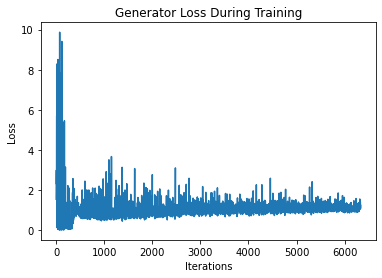

In [11]:
plt.title("Generator Loss During Training")
plt.plot(d_loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

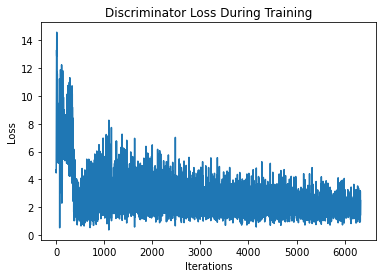

In [12]:
plt.title("Discriminator Loss During Training")
plt.plot(g_loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In this project, I built a GAN framework to implement the task of generating fake images. To do that, I expanded on the linear layers structure of the discriminator and generator by building a DCGAN. A DCGAN is a direct improvement of GANs that uses convolutional layers and convolutional transpose layers to improve perfomance. I read the paper by Alec Radford, Luke Metz, and Soumith Chintala and the pytorch dcgan tutorial to create the generator and dicriminator modules.

Paper reference: https://arxiv.org/pdf/1511.06434.pdf

The discriminator is made up of convolution layers, batch norm layers, and LeakyReLU activations that take the size of the image as an input and then outputs the probabiity that the image is from the same data distribution.
The generator is made up from convolutional transpose layers, batch norm layers, and ReLU activations that take the latent vector z (initialized to 100 in my code) and outputs the image.
All of the improvements can be found in the paper referenced above. The inclusion of a batch norm layers transpose layer in the generator and discriminator allows the gradient to flow better. The writers of the paper also consider it good practice to use convolution layers.

To calculate the loss, I created the real labels and fake labels with 1 and 0 respectively as indicated in the psuedocode. I used those labels to calculate the losses of the discriminator and generator. 